In [1]:
from __future__ import print_function, division
from builtins import range

In [3]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from sklearn.metrics import roc_auc_score


In [4]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10


In [7]:
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('C:/Users/hp/Desktop/DeepLearningCodes/glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM), encoding="utf8") as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [14]:
train = pd.read_csv("C:/Users/hp/Desktop/DeepLearningCodes/MultiLabelling/train/train.csv")
sentences = train["comment_text"].fillna("DUMMY_VALUE").values
possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
targets = train[possible_labels].values


In [15]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)#taking tokens
tokenizer.fit_on_texts(sentences)#fitting trokens
sequences = tokenizer.texts_to_sequences(sentences)#Converting 2 Numbers

In [24]:
print(tokenizer.index_word[985]); 

27


In [23]:
print(sequences[0])

[688, 75, 1, 126, 130, 177, 29, 672, 4511, 12051, 1116, 86, 331, 51, 2278, 11448, 50, 6864, 15, 60, 2756, 148, 7, 2937, 34, 117, 1221, 15190, 2825, 4, 45, 59, 244, 1, 365, 31, 1, 38, 27, 143, 73, 3462, 89, 3085, 4583, 2273, 985]


In [25]:

print("max sequence length:", max(len(s) for s in sequences))
print("min sequence length:", min(len(s) for s in sequences))
s = sorted(len(s) for s in sequences)
print("median sequence length:", s[len(s) // 2])


max sequence length: 1400
min sequence length: 0
median sequence length: 35


In [26]:

# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))


Found 210333 unique tokens.


In [27]:

# pad sequences so that we get a N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

Shape of data tensor: (159571, 100)


In [28]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector


Filling pre-trained embeddings...


In [29]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)

In [30]:
print('Building model...')


Building model...


In [31]:
  # train a 1D convnet with global maxpooling
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)


In [ ]:


#input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
#x = embedding_layer(input_)
#x=LSTM(15, return_sequences=True)(x)#If you dont want output of internal values write False
#x=GlobalMaxPool1D()(x)
#output = Dense(len(possible_labels), activation='sigmoid')(x)

In [ ]:
#input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
#x = embedding_layer(input_)
#x=Bidirectional(LSTM(15, return_sequences=True))(x)#If you dont want output of internal values write False
#x=GlobalMaxPool1D()(x)
#output = Dense(len(possible_labels), activation='sigmoid')(x)

In [32]:
  model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)


In [33]:
print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)


Training model...
Train on 127656 samples, validate on 31915 samples
Epoch 1/10
127656/127656 [==============================] - 401s 3ms/step - loss: 0.0853 - acc: 0.9725 - val_loss: 0.0855 - val_acc: 0.9740
Epoch 2/10
127656/127656 [==============================] - 414s 3ms/step - loss: 0.0678 - acc: 0.9773 - val_loss: 0.0703 - val_acc: 0.9774
Epoch 3/10
127656/127656 [==============================] - 359s 3ms/step - loss: 0.0631 - acc: 0.9785 - val_loss: 0.0661 - val_acc: 0.9776
Epoch 4/10
127656/127656 [==============================] - 361s 3ms/step - loss: 0.0600 - acc: 0.9791 - val_loss: 0.0808 - val_acc: 0.9766
Epoch 5/10
127656/127656 [==============================] - 353s 3ms/step - loss: 0.0573 - acc: 0.9797 - val_loss: 0.0719 - val_acc: 0.9769
Epoch 6/10
127656/127656 [==============================] - 1172s 9ms/step - loss: 0.0552 - acc: 0.9803 - val_loss: 0.0738 - val_acc: 0.9765
Epoch 7/10
127656/127656 [==============================] - 356s 3ms/step - loss: 0.0537 -

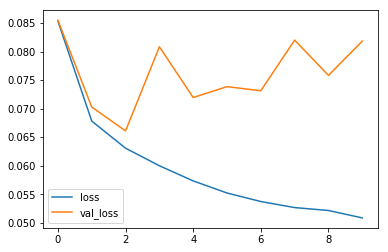

In [34]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

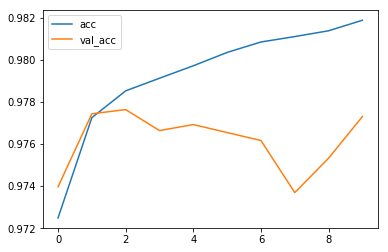

In [35]:
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [36]:
# plot the mean AUC over each label
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

0.9762784224696079
